In [7]:
import pyodbc
import pandas as pd

##Pulling Application table from schema in system

query= "SELECT * FROM mrp.hhspplciationtable;"

with pyodbc.connect("DSN=impala-prod",autocommit=True) as impala_conn:
    df = pd.read_sql(query, impala_conn)
    


C:\Users\shaun.rolph\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
## Filter the DataFrame to keep only the desired columns
desired_columns = [
    'app_no',
    'app_score',
    'requested_project_start_date',
    'funding_oppurtunity_title',
    'app_status', 
    'fed_approved_amount', 
    'requested_federal_amount', 
    'grant_program_id', 
    'grant_number', 
    '424_federal', 
    'recommended_federal_amount', 
    'applicant_name', 
    'applicant_ein', 
    'app_org_state', 
    'app_org_zip', 
    'cfda_name', 
    'title_of_applicants_project', 
    'grantee_id',
    'grant_program_id',
]

### Update df to contain only the desired columns
df2 = df[desired_columns]


In [10]:
## Making sure I only have the variables I need
for d in df2.columns:
    print(d)

app_no
app_score
requested_project_start_date
funding_oppurtunity_title
app_status
fed_approved_amount
requested_federal_amount
grant_program_id
grant_number
424_federal
recommended_federal_amount
applicant_name
applicant_ein
app_org_state
app_org_zip
cfda_name
title_of_applicants_project
grantee_id
grant_program_id


In [11]:
##Checking shape before I filter by grant program
df2.shape[0]

23300

In [12]:
##Filters based on the most competative grant progams I want to analize
desired_cfda_names = [
    'Farmers Market Promotion Program',
    'Local Food Promotion Program',
    'Regional Food System Partnerships'
]

df3 = df2[df2['funding_oppurtunity_title'].isin(desired_cfda_names)]


In [7]:
##Checking it after
df3.shape[0]

2281

In [13]:
##Deduping and checking shape again
df3 = df3.drop_duplicates(subset="app_no")
df3.shape[0]

2362

In [14]:
##Checking for NA's

nan_counts = df3.isna().sum()
print(nan_counts)

app_no                             0
app_score                        448
requested_project_start_date       0
funding_oppurtunity_title          0
app_status                         0
fed_approved_amount             1866
requested_federal_amount           0
grant_program_id                   0
grant_number                       0
424_federal                        0
recommended_federal_amount      1827
applicant_name                     0
applicant_ein                      1
app_org_state                      2
app_org_zip                        2
cfda_name                          2
title_of_applicants_project        0
grantee_id                         0
grant_program_id                   0
dtype: int64


In [15]:
##Creating a dummy variable for if a applicaiton was accepted or not 

df3['App_Approved_Dummy'] = df3['fed_approved_amount'].notnull().astype(int)

In [16]:
##Getting counts for appected dummy variable

dummy_counts = df3['App_Approved_Dummy'].value_counts()
print(dummy_counts)

0    1866
1     496
Name: App_Approved_Dummy, dtype: int64


In [17]:
##Getting counts for appected dummy variable by state

dummy_counts_states = df3.groupby('app_org_state')['App_Approved_Dummy'].value_counts()
dummy_counts_states= dummy_counts_states.unstack(fill_value=0)

In [18]:
##setting up Year vairable and cleaning

df3['requested_project_start_date'] = pd.to_datetime(df2['requested_project_start_date'])
df3['requested_project_start_date'] = df3['requested_project_start_date'].dt.year
df3['requested_project_start_date'] = df3['requested_project_start_date'].replace(2024, 2023)

In [19]:
##Removing some of the years that are errors

dummy_counts_fy = df3.groupby('requested_project_start_date')['App_Approved_Dummy'].value_counts()
dummy_counts_fy= dummy_counts_fy.unstack(fill_value=0)

In [20]:
##Removing everything that isnt in year 2021 to 2023 and getting counts

df3 = df3[df3['requested_project_start_date'].isin([2021,2022,2023])]
df3.requested_project_start_date.value_counts()

2021    730
2023    639
2022    451
Name: requested_project_start_date, dtype: int64

In [21]:
##Bringing in Region data to merge with applciaiton data
df_region = pd.read_excel(r'C:\Users\shaun.rolph\Desktop\Capstone\State_and_Region.xlsx', sheet_name='Sheet1')

In [22]:
##Merging in Region and Division into the dataset

## Merge df and df_region on the 'app_org_state' variable
df4 = pd.merge(df3, df_region[['State Code', 'Region', 'Division']], left_on='app_org_state', right_on='State Code', how='left')

## Drop the 'state' column
df4.drop(columns=['State Code'], inplace=True)



In [23]:
##Check Shape of DF4
df4.shape[0]

1820

In [23]:
## Now that I am happy with the complete applicaiton DS I am Exporting Application Dataset to folder in Desktop
##I will then bring this into Tableau for visual analysis
excel_file_path = r'C:\Users\shaun.rolph\OneDrive - USDA\Desktop\Capstone Export\applicationDS.xlsx'
df4.to_excel(excel_file_path, index=False)


In [24]:
##Checking year counts
df4.requested_project_start_date.value_counts()

2021    730
2023    639
2022    451
Name: requested_project_start_date, dtype: int64

In [25]:
## Creating a new dataframe which will pivot the data on year and state. 
## I am calculating mean accepance rate and count of applicaitons for each state by year. 

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
## Group by state and year, and calculate acceptance rate
acceptance_rate_by_state_year = df4.groupby(['app_org_state', 'requested_project_start_date'])['App_Approved_Dummy'].mean().reset_index()

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
# Group by state and year, and calculate total application count
total_applications_by_state_year = df4.groupby(['app_org_state', 'requested_project_start_date'])['app_no'].count().reset_index()

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
## Merge the acceptance rate and total application count dataframes on state and year
combined_df = pd.merge(acceptance_rate_by_state_year, total_applications_by_state_year, on=['app_org_state', 'requested_project_start_date'])

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
## Pivot the data to have each year's acceptance rate and total application count as separate columns
acceptance_rate_count_pivot = combined_df.pivot_table(index='app_org_state', columns='requested_project_start_date', values=['App_Approved_Dummy', 'app_no'], fill_value=0)

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
## Rename the columns
acceptance_rate_count_pivot.columns = ['acceptance_rate_2021', 'acceptance_rate_2022', 'acceptance_rate_2023', 'total_applications_2021', 'total_applications_2022', 'total_applications_2023']

## I am calculating accepance rate and count of applicaitons for eahc state by year. 
## Reset index to make 'app_org_state' a column
acceptance_rate_count_pivot.reset_index(inplace=True)
# Print the DataFrame to verify the changes


In [26]:
## Now I am converting the data into long format so I can do indepth analysis with pooled applciaiton numbers as well as mean acceptance rates

## Melt the DataFrame to long format

melted_df = acceptance_rate_count_pivot.melt(id_vars='app_org_state',
                                             value_vars=['acceptance_rate_2021', 'acceptance_rate_2022', 'acceptance_rate_2023',
                                                         'total_applications_2021', 'total_applications_2022', 'total_applications_2023'],
                                             var_name='year',
                                             value_name='value')

## Combine 'app_org_state' and 'year' to create 'State_Year' column

melted_df['State_Year'] = melted_df['app_org_state'] + '_' + melted_df['year'].str[-4:]

## Extract state from 'State_Year' column

melted_df['State'] = melted_df['State_Year'].str.split('_').str[0]
melted_df['Year'] = melted_df['State_Year'].str.split('_').str[1]

## Separate acceptance rates and application counts into two separate DataFrames

acceptance_df = melted_df[melted_df['year'].str.contains('acceptance_rate')].copy()
application_count_df = melted_df[melted_df['year'].str.contains('total_applications')].copy()

## Reset index

acceptance_df.reset_index(drop=True, inplace=True)
application_count_df.reset_index(drop=True, inplace=True)

## Drop unnecessary columns

acceptance_df.drop(columns=['app_org_state', 'year', 'State_Year'], inplace=True)
application_count_df.drop(columns=['app_org_state', 'year', 'State_Year'], inplace=True)

## Rename value columns

acceptance_df.rename(columns={'value': 'Acceptance_Rate'}, inplace=True)
application_count_df.rename(columns={'value': 'Application_Count'}, inplace=True)

## Merge the acceptance rates and application counts into a single DataFrame

final_df = pd.concat([acceptance_df, application_count_df], axis=1)

## Print the first few rows of the final DataFrame to verify the changes



In [27]:
## Removing Last two rows of final_df
final_df = final_df.iloc[:, :-2]

In [28]:
##Checking year counts
final_df.Year.value_counts()

2021    55
2022    55
2023    55
Name: Year, dtype: int64

In [29]:
## Decided to include average applicaiton score by state by year so I created the varibale needed to merge the data together

final_df['state_year'] = final_df['State'] + final_df['Year']

In [30]:
## Setting up the column to calculate the average score by state per year 

## Assuming df is your DataFrame and 'column1' and 'column2' are the columns you want to concatenate
df4['state_year'] = df4['app_org_state'].astype(str).str.cat(df4['requested_project_start_date'].astype(str))

score_apps = df4.groupby('state_year')['app_score'].mean().reset_index()

In [31]:
final_df2 = pd.merge(score_apps,final_df, on='state_year', how='right')

In [32]:
##Renaming some table for final export
final_df2 = final_df2.rename(columns= {'app_score' : 'Average Applicaiton Score', 'Acceptance_Rate' : 'Average Applicaiton Acceptance Rate by State' })


In [33]:
## Adding Region data to final_df2

final_df2 = pd.merge(final_df2, df_region[['State Code', 'Region', 'Division']], left_on='State', right_on='State Code', how='left')


In [34]:
##Checking year counts
final_df2.Year.value_counts()

2021    55
2022    55
2023    55
Name: Year, dtype: int64

In [95]:
##Expoting Pooled datasetDataset to fodler in Desktop for analysis in Tableau
excel_file_path = r'C:\Users\shaun.rolph\OneDrive - USDA\Desktop\Capstone Export\application_pooled_acceptance_rates.xlsx'
final_df2.to_excel(excel_file_path, index=False)

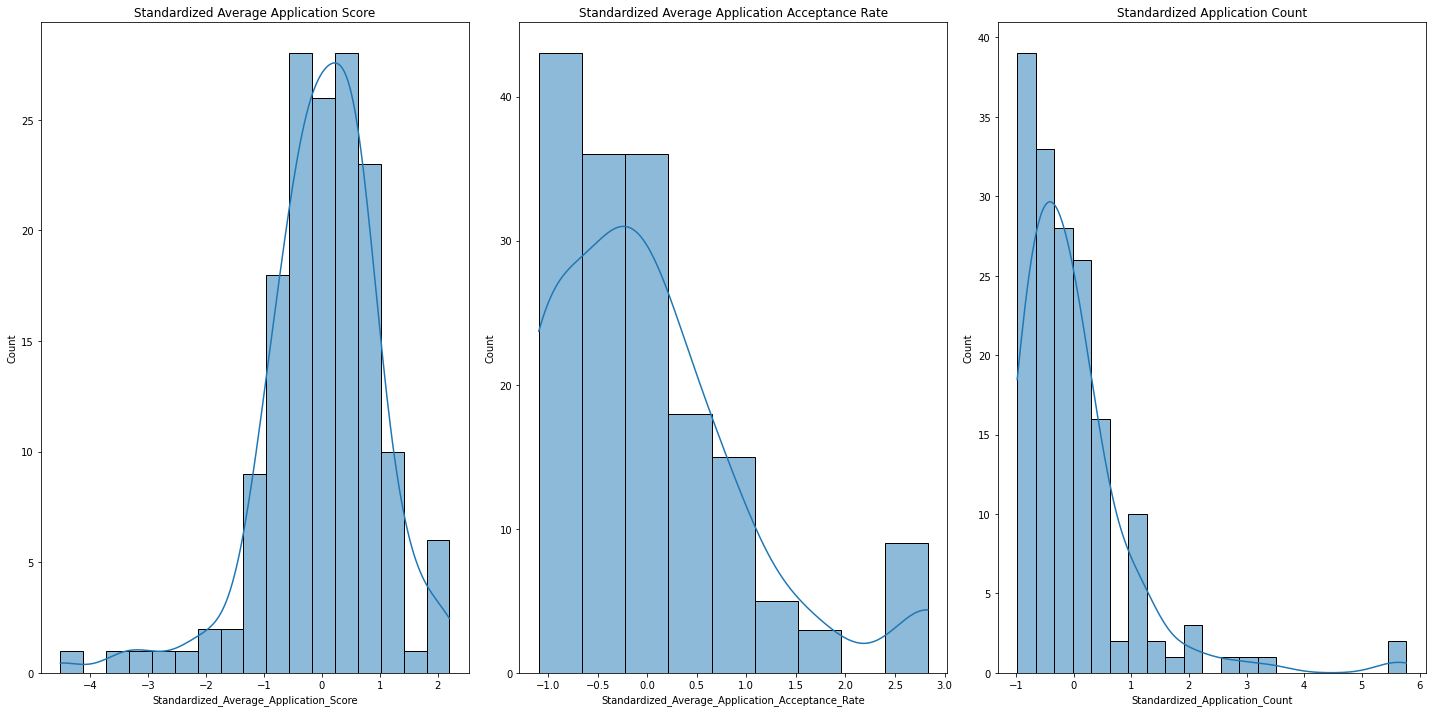

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the columns using Z-score normalization
final_df2['Standardized_Average_Application_Score'] = (final_df2['Average Applicaiton Score'] - final_df2['Average Applicaiton Score'].mean()) / final_df2['Average Applicaiton Score'].std()
final_df2['Standardized_Average_Application_Acceptance_Rate'] = (final_df2['Average Applicaiton Acceptance Rate by State'] - final_df2['Average Applicaiton Acceptance Rate by State'].mean()) / final_df2['Average Applicaiton Acceptance Rate by State'].std()
final_df2['Standardized_Application_Count'] = (final_df2['Application_Count'] - final_df2['Application_Count'].mean()) / final_df2['Application_Count'].std()

# Plot histograms
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.histplot(final_df2['Standardized_Average_Application_Score'], kde=True)
plt.title('Standardized Average Application Score')

plt.subplot(1, 3, 2)
sns.histplot(final_df2['Standardized_Average_Application_Acceptance_Rate'], kde=True,)
plt.title('Standardized Average Application Acceptance Rate')

plt.subplot(1, 3, 3)
sns.histplot(final_df2['Standardized_Application_Count'], kde=True,)
plt.title('Standardized Application Count')

plt.tight_layout()
plt.show()


In [97]:
## Exporting Pooled datasetDataset to fodler in Desktop for analysis in Tableau
excel_file_path = r'C:\Users\shaun.rolph\OneDrive - USDA\Desktop\Capstone Export\application_pooled_acceptance_rates.xlsx'
final_df2.to_excel(excel_file_path, index=False)

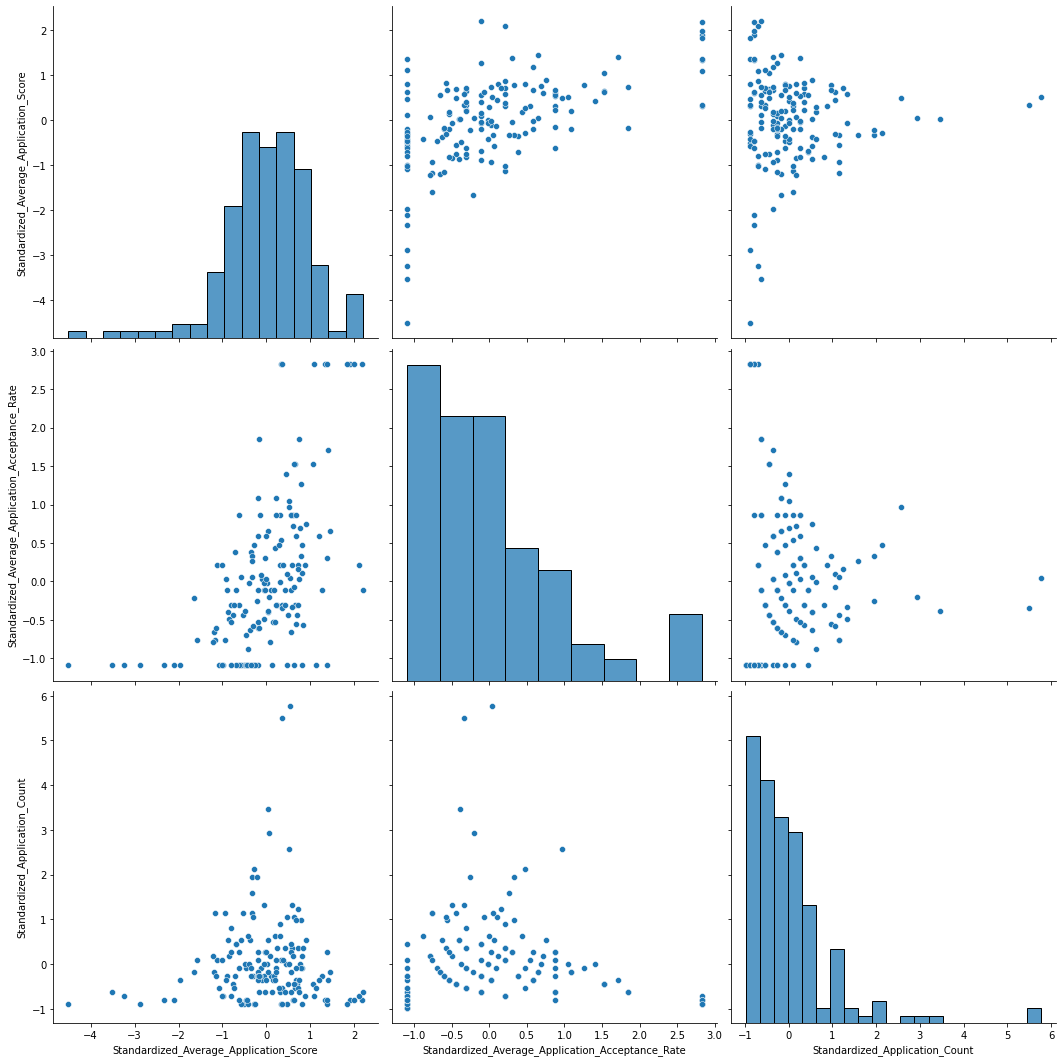

In [36]:
import seaborn as sns

# Select the variables for the scatter plot matrix
variables = ['Standardized_Average_Application_Score', 'Standardized_Average_Application_Acceptance_Rate', 'Standardized_Application_Count']

# Create the scatter plot matrix
sns.pairplot(final_df2[variables], height=5)
plt.show()


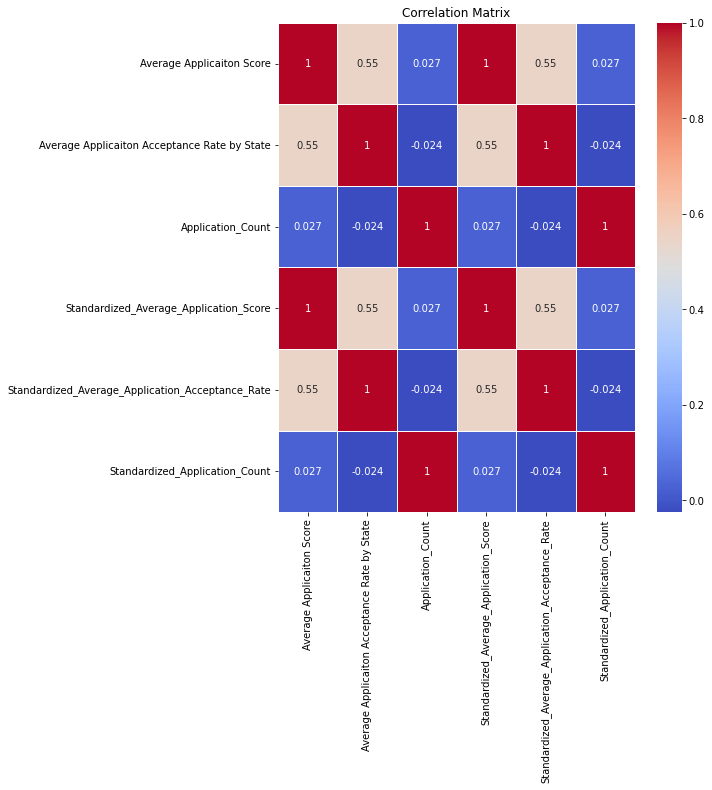

In [37]:
Selected_Corr_var = ['']


corr_matrix = final_df2.corr()
plt.figure(figsize=(8,9))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidth=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
###This OLS Regression is just focused on difference within accetpance rates for 2021 to 2023, Time Series

import pandas as pd
import statsmodels.api as sm

# Convert 'Year' column to numeric
final_df2['Year'] = pd.to_numeric(final_df2['Year'], errors='coerce')

# Calculate the difference in acceptance rates for each state
final_df2['Acceptance_Rate_Difference'] = final_df2.groupby('State')['Average Applicaiton Acceptance Rate by State'].transform(lambda x: x.diff())

# Drop NaN values resulting from the diff operation
final_df2.dropna(subset=['Acceptance_Rate_Difference'], inplace=True)

# Prepare the data for regression
X = sm.add_constant(final_df2['Year'])  # Independent variable
y = final_df2['Acceptance_Rate_Difference']  # Dependent variable

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary

In [ ]:
###This OLS Regression is just focused on difference within accetpance rates by region

from statsmodels.api import add_constant
from statsmodels.api import OLS
import pandas as pd
import numpy as np


final_df2_numeric = final_df2.select_dtypes(include=[np.number])

# Impute NaN values with the mean for numerical columns (a simple but effective strategy for this context)
for column in final_df2_numeric.columns:
    final_df2_numeric[column].fillna(final_df2_numeric[column].mean(), inplace=True)

# Re-encode the Region variable after handling NaNs
final_df2_with_dummies_corrected = pd.get_dummies(final_df2_numeric.join(final_df2['Region']), columns=['Region'], drop_first=True)

# Redefine predictors (X) and dependent variable (y) with the cleaned data
X_final_df2_corrected = final_df2_with_dummies_corrected[['Average Applicaiton Score', 'Application_Count'] + [col for col in final_df2_with_dummies_corrected.columns if 'Region_' in col]]
y_final_df2_corrected = final_df2_with_dummies_corrected['Average Applicaiton Acceptance Rate by State']

# Add a constant to the model (the intercept)
X_final_df2_corrected = add_constant(X_final_df2_corrected)

# Perform the OLS regression again with the cleaned data
model_final_df2_corrected = OLS(y_final_df2_corrected, X_final_df2_corrected).fit()

# Summarize the results of the regression with the cleaned data
model_summary_final_df2_corrected = model_final_df2_corrected.summary()
model_summary_final_df2_corrected


In [42]:
import matplotlib.pyplot as plt

# Convert the summary to a string
model_summary_str = model_summary_final_df2_corrected.as_text()

# Create a figure and axis to plot the text
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed
ax.text(0.5, 0.5, model_summary_str, horizontalalignment='center', verticalalignment='center', fontsize=12, family='monospace')
plt.axis('off')

# Save the figure
plt.savefig(r'C:\Users\shaun.rolph\OneDrive - USDA\Desktop\Capstone Export\ols_regression_summary.png', bbox_inches='tight')
plt.close()



In [ ]:
###This OLS Regression is just focused on difference within accetpance rates by state

from statsmodels.api import add_constant
from statsmodels.api import OLS

final_df2_numeric = final_df2.select_dtypes(include=[np.number])

# Impute NaN values with the mean for numerical columns (a simple but effective strategy for this context)
for column in final_df2_numeric.columns:
    final_df2_numeric[column].fillna(final_df2_numeric[column].mean(), inplace=True)

# Re-encode the Region variable after handling NaNs
final_df2_with_dummies_corrected = pd.get_dummies(final_df2_numeric.join(final_df2['State']), columns=['State'], drop_first=True)

# Redefine predictors (X) and dependent variable (y) with the cleaned data
X_final_df2_corrected = final_df2_with_dummies_corrected[['Average Applicaiton Score', 'Application_Count'] + [col for col in final_df2_with_dummies_corrected.columns if 'State_' in col]]
y_final_df2_corrected = final_df2_with_dummies_corrected['Average Applicaiton Acceptance Rate by State']

# Add a constant to the model (the intercept)
X_final_df2_corrected = add_constant(X_final_df2_corrected)

# Perform the OLS regression again with the cleaned data
model_final_df2_corrected = OLS(y_final_df2_corrected, X_final_df2_corrected).fit()

# Summarize the results of the regression with the cleaned data
model_summary_final_df2_corrected = model_final_df2_corrected.summary()
model_summary_final_df2_corrected
